<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/07_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 一般線形モデル (GLM; generalized linear model)
* 今回はロジスティック回帰を採り上げる。
* データセットは、以下のexamplesで扱われていたものを使う。
 * https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html


## 7.0 一般線形モデルとは
### 7.0.1 線形回帰
 * 線形回帰は、以下のように定式化できる。
$$ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots \beta_d X_d + \epsilon $$
 * $\beta_0, \beta_1, \ldots, \beta_d$が推定すべき係数。
 * $\beta = (\beta_0, \beta_1, \ldots, \beta_d)$、$X = (1, X_1, \ldots, X_d)$とおくと、上式は以下のように書ける。
$$ Y = \beta^\top X + \epsilon $$
* 最小二乗法では、誤差項$\epsilon$が正規分布に従うと仮定し、最尤推定で推定する。


### 7.0.2 線形モデルのgeneralization
* 線形回帰では、正規分布の平均$\mu$が$\beta^\top X$に等しい、と置いている。
 * つまり、$\mu = E[Y | X] = \beta^\top X$と置いている。
* 正規分布以外の分布でも、その分布の平均を$\beta^\top X$の関数で表すことで、正規分布ではモデリングしにくいデータのモデリングに線形モデルを使う可能性が広がる。

### 7.0.3 ロジスティック回帰
* ロジスティック回帰では、正規分布ではなく、ベルヌーイ分布を観測データのモデリングに用いる。
* ベルヌーイ分布の平均$\mu$は、outcomeが$1$となる確率である。
* $\beta^\top X$を$[0,1]$の区間の値に変換するために、シグモイド関数$\mu(s) = \frac{1}{1 + e^{- s}}$を使う。
* ということは、各データ点$\textbf{x}_i = (x_{i,1}, \ldots, x_{i,d})$に対応する、outcomeが$1$となる確率を$p_i = \frac{1}{1 + e^{- \beta^\top \textbf{x}_i}}$として・・・
* 0か1かの正解ラベルを$t_i$と書くと、$\sum_i \{ t_i \log p_i + (1 - t_i) \log (1 - p_i) \}$の最大化によって、最尤推定を行うことができる。
 * ロジスティック回帰の場合のシグモイド関数のような関数を、GLMにおける平均関数(mean function)と呼ぶ。
 * mean functionの逆関数を、リンク関数(link function)と呼ぶ。

### 7.0.4 ポアソン回帰
* ポアソン回帰では、正規分布ではなく、ポアソン分布を観測データのモデリングに用いる。
* ポアソン分布の平均$\mu$は、ポアソン分布の唯一のパラメータそのものである。このパラメータが取る値の範囲は$(0,\infty)$である。
* $\beta^\top X$を$[0,1]$の区間の値に変換するために、指数関数を使う。
* ということは、各データ点$\textbf{x}_i = (x_{i,1}, \ldots, x_{i,d})$に対応するポアソン分布のパラメータを$\lambda_i = e^{\beta^\top \textbf{x}_i}$として・・・
* 正解の回数を$c_i$と書くと、$\sum_i \{ c_i \log \lambda_i - \lambda_i \}$の最大化によって、最尤推定を行うことができる。
 * ポアソン回帰の場合の平均関数は、指数関数。
 * ということは、リンク関数は、対数関数。

### 7.0.5 一般線形モデルのベイズ化
* 一般線形モデルのベイズ化は、線形回帰と同様、係数と切片に事前分布を導入することで行われる。
* PyMC3では、リンク関数を指定する点を除いて、コードの上では大差ない。
 * もちろん、結果の解釈方法は、全く異なる。



---



In [1]:
!pip install arviz
!pip install git+https://github.com/pyro-ppl/numpyro.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyro-ppl/numpyro.git to /tmp/pip-req-build-dvjg6yj4
  Running command git clone --filter=blob:none --quiet https://github.com/pyro-ppl/numpyro.git /tmp/pip-req-build-dvjg6yj4
  Resolved https://github.com/pyro-ppl/numpyro.git to commit f981b29f0fbe7e99d50f3b4f56ad5eff7d6c6f37
  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

plt.style.use("bmh")
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("gpu") # 今回はGPUを使うことにする。

## 7.1 データ

* UCI機械学習リポジトリにあるAdult Data Set
 * http://archive.ics.uci.edu/ml/datasets/Adult
* 個人が年間5万ドルを稼ぐかどうかを予測する。

* 直下のセルのコードは、以下のリンク先を参考にした。
 * https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html

In [3]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
           "age",
          "workclass",
          "fnlwgt",
          "education-categorical",
          "educ",
          "marital-status",
          "occupation",
          "relationship",
          "race",
          "sex",
          "captial-gain",
          "capital-loss",
          "hours",
          "native-country",
          "income",
    ],
)

In [4]:
raw_data.head()

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


* fnlwgt (final weight) は後から何らかのプログラムによって計算されて追加されたものらしい。

In [5]:
raw_data.describe()

,age,fnlwgt,educ,captial-gain,capital-loss,hours
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    32561 non-null  int64 
 1   workclass              32561 non-null  object
 2   fnlwgt                 32561 non-null  int64 
 3   education-categorical  32561 non-null  object
 4   educ                   32561 non-null  int64 
 5   marital-status         32561 non-null  object
 6   occupation             32561 non-null  object
 7   relationship           32561 non-null  object
 8   race                   32561 non-null  object
 9   sex                    32561 non-null  object
 10  captial-gain           32561 non-null  int64 
 11  capital-loss           32561 non-null  int64 
 12  hours                  32561 non-null  int64 
 13  native-country         32561 non-null  object
 14  income                 32561 non-null  object
dtypes: int64(6), object

* アメリカのデータに限定して分析する。

In [7]:
data = raw_data[raw_data["native-country"] == " United-States"]

In [8]:
data.sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
14783,36,Self-emp-not-inc,151094,Assoc-voc,11,Separated,Exec-managerial,Not-in-family,White,Male,0,0,48,United-States,<=50K
6234,22,Self-emp-inc,269583,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,2580,0,40,United-States,<=50K
368,57,Private,212448,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,>50K
18876,39,Private,163237,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,<=50K
15087,62,Private,664366,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K


* incomeが50Kドルより大きいか否かという1/0の情報でincome列を置き換える。
* 特徴量としてはage, educ, hoursだけを取り出す。
* この分析例では、ageの2乗を新たな特徴量として追加している。

In [9]:
income = 1 * (data.income == " >50K")

In [10]:
income.value_counts()

0    21999
1     7171
Name: income, dtype: int64

* 使用する特徴量は、以下の3つ。

In [11]:
data = data[["age", "educ", "hours"]]

* 年齢を10で割っておく。
 * こうしたほうが、convergenceが良くなるらしい。
* 10で割った年齢の2乗を新たな特徴量として追加する。
 * なぜ？

In [12]:
# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

In [13]:
data["educ"].value_counts().sort_index()

1       17
2       46
3       97
4      499
5      395
6      848
7     1067
8      365
9     9702
10    6740
11    1289
12     982
13    4766
14    1527
15     502
16     328
Name: educ, dtype: int64

In [14]:
data.describe()

,age,educ,hours,age2,income
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,3.865567,10.169455,40.447755,16.825591,0.245835
std,1.372241,2.394966,12.417203,11.859015,0.430588
min,1.700000,1.000000,1.000000,2.890000,0.000000
25%,2.800000,9.000000,40.000000,7.840000,0.000000
50%,3.700000,10.000000,40.000000,13.690000,0.000000
75%,4.800000,12.000000,45.000000,23.040000,0.000000
max,9.000000,16.000000,99.000000,81.000000,1.000000


## 7.2 EDA

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


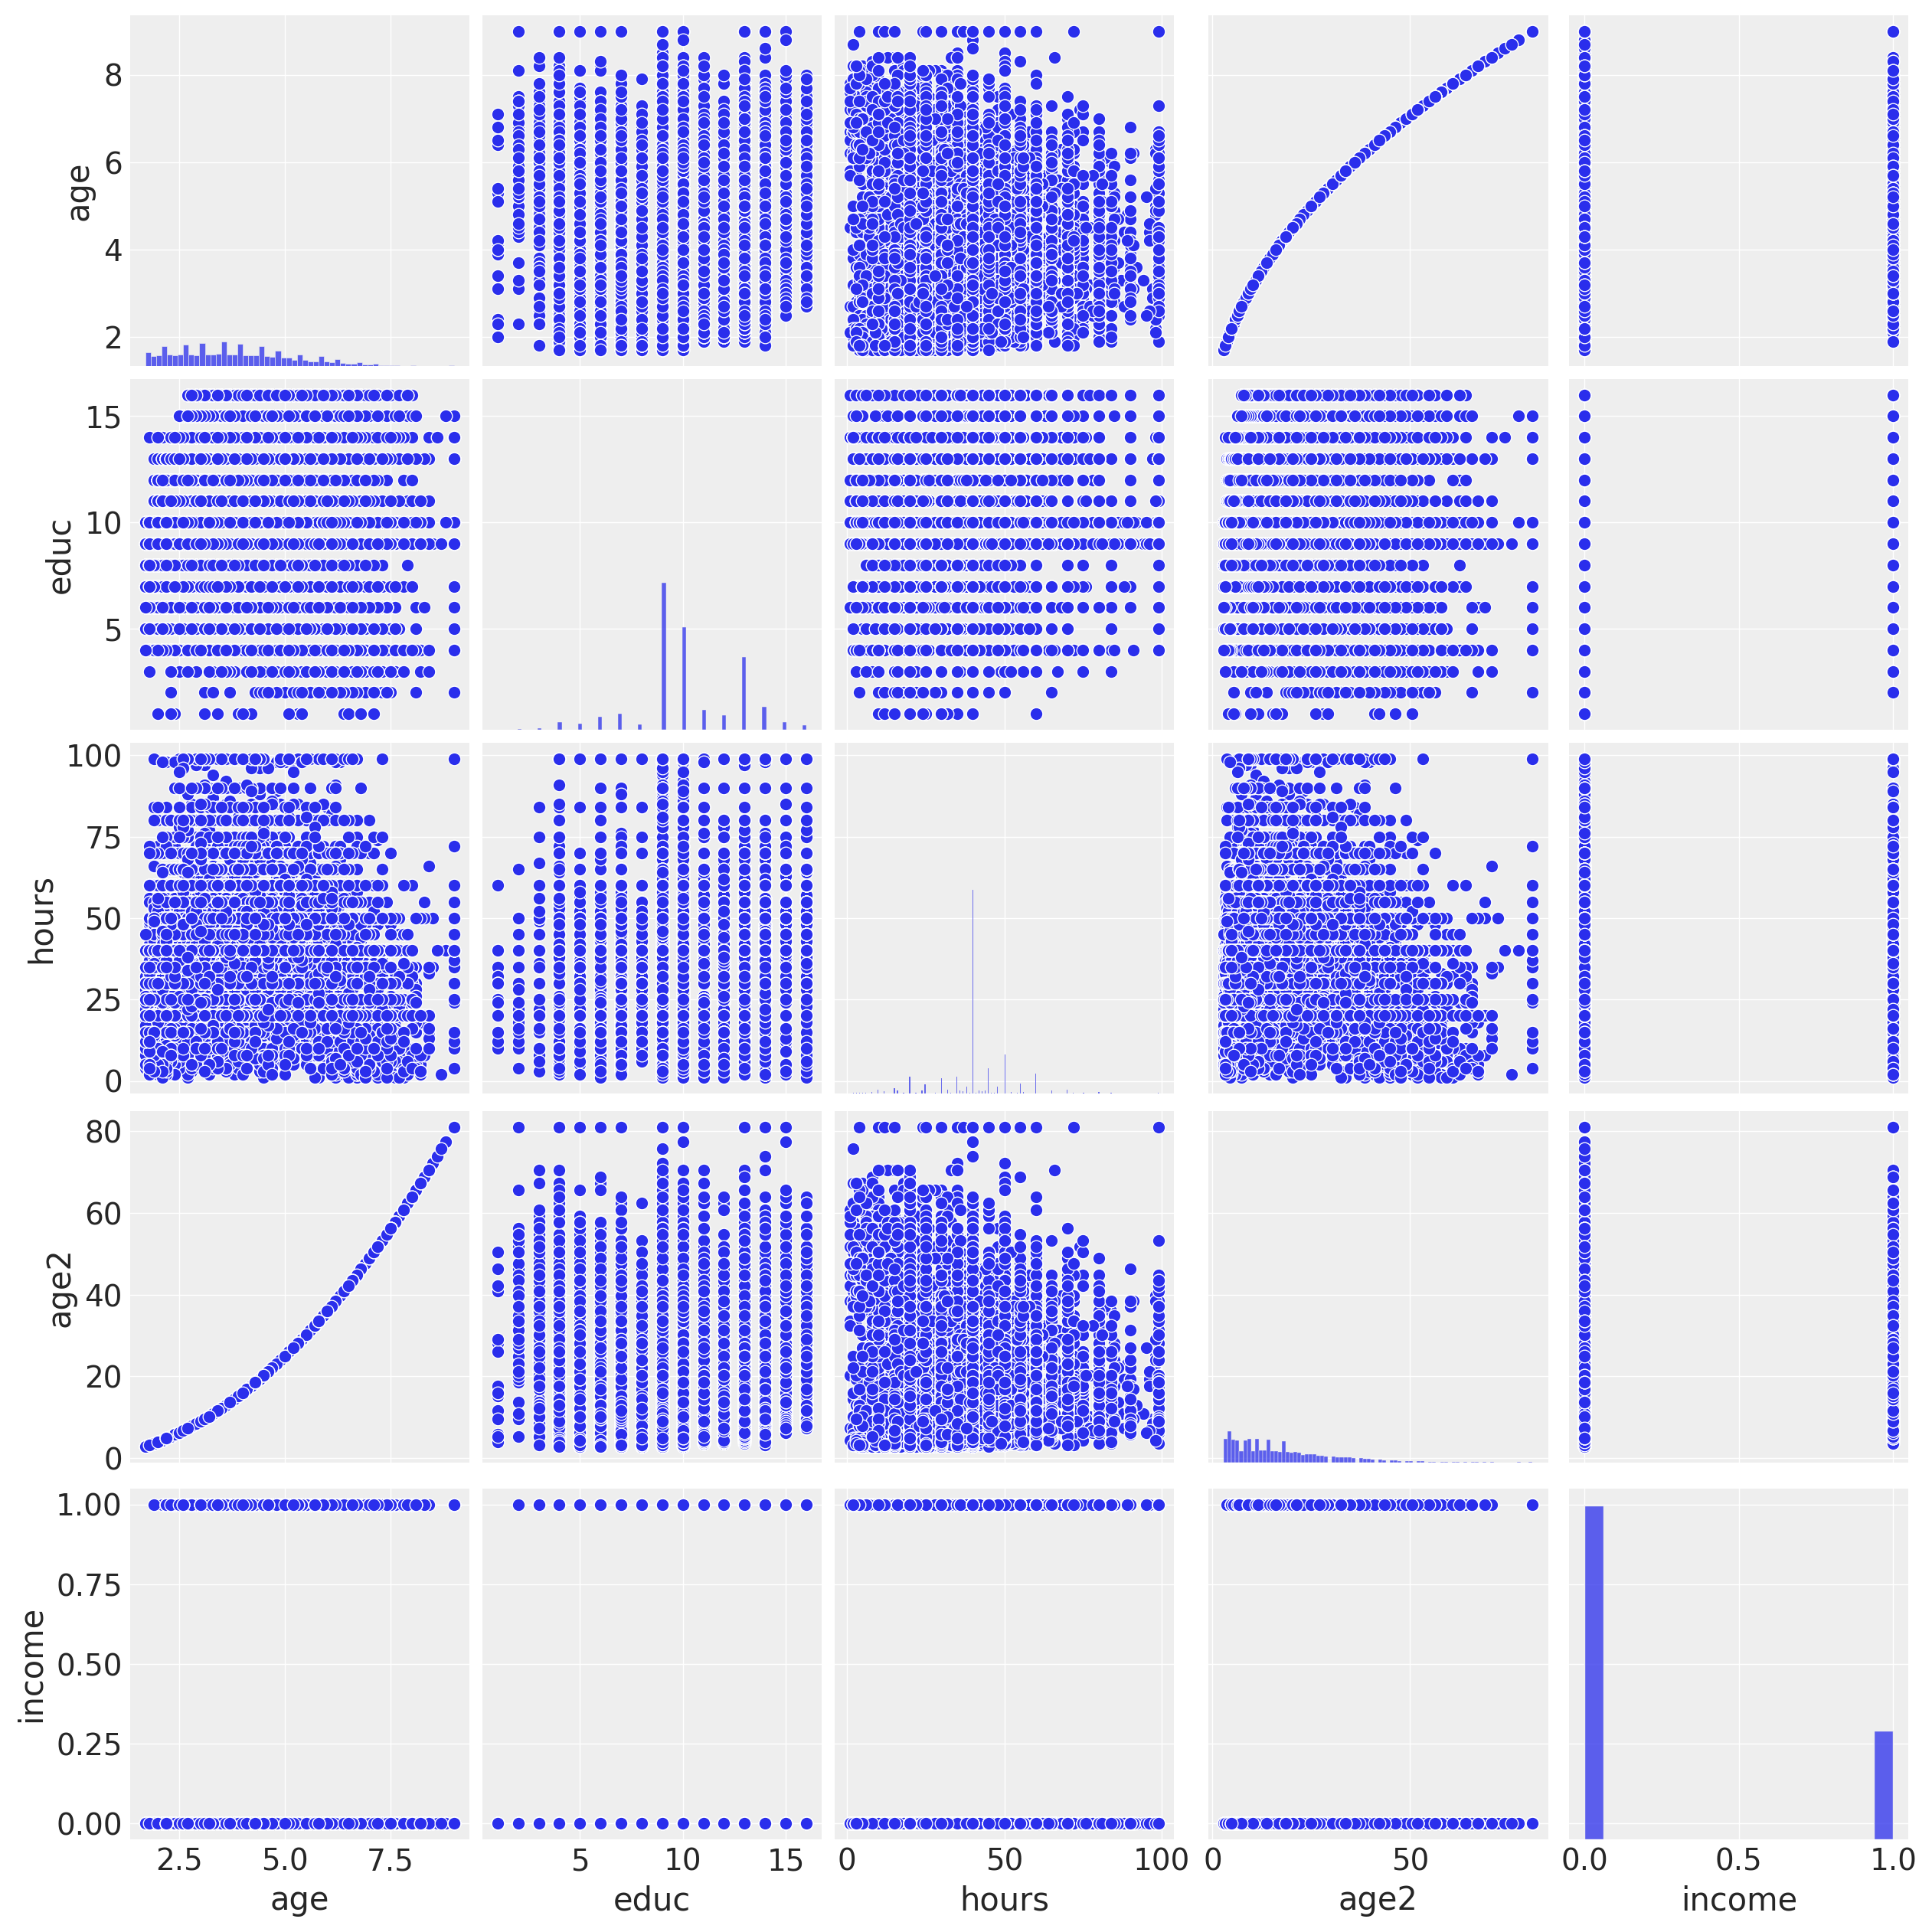

In [15]:
sns.pairplot(data);

<ipython-input-16-9a00d0fc7776>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


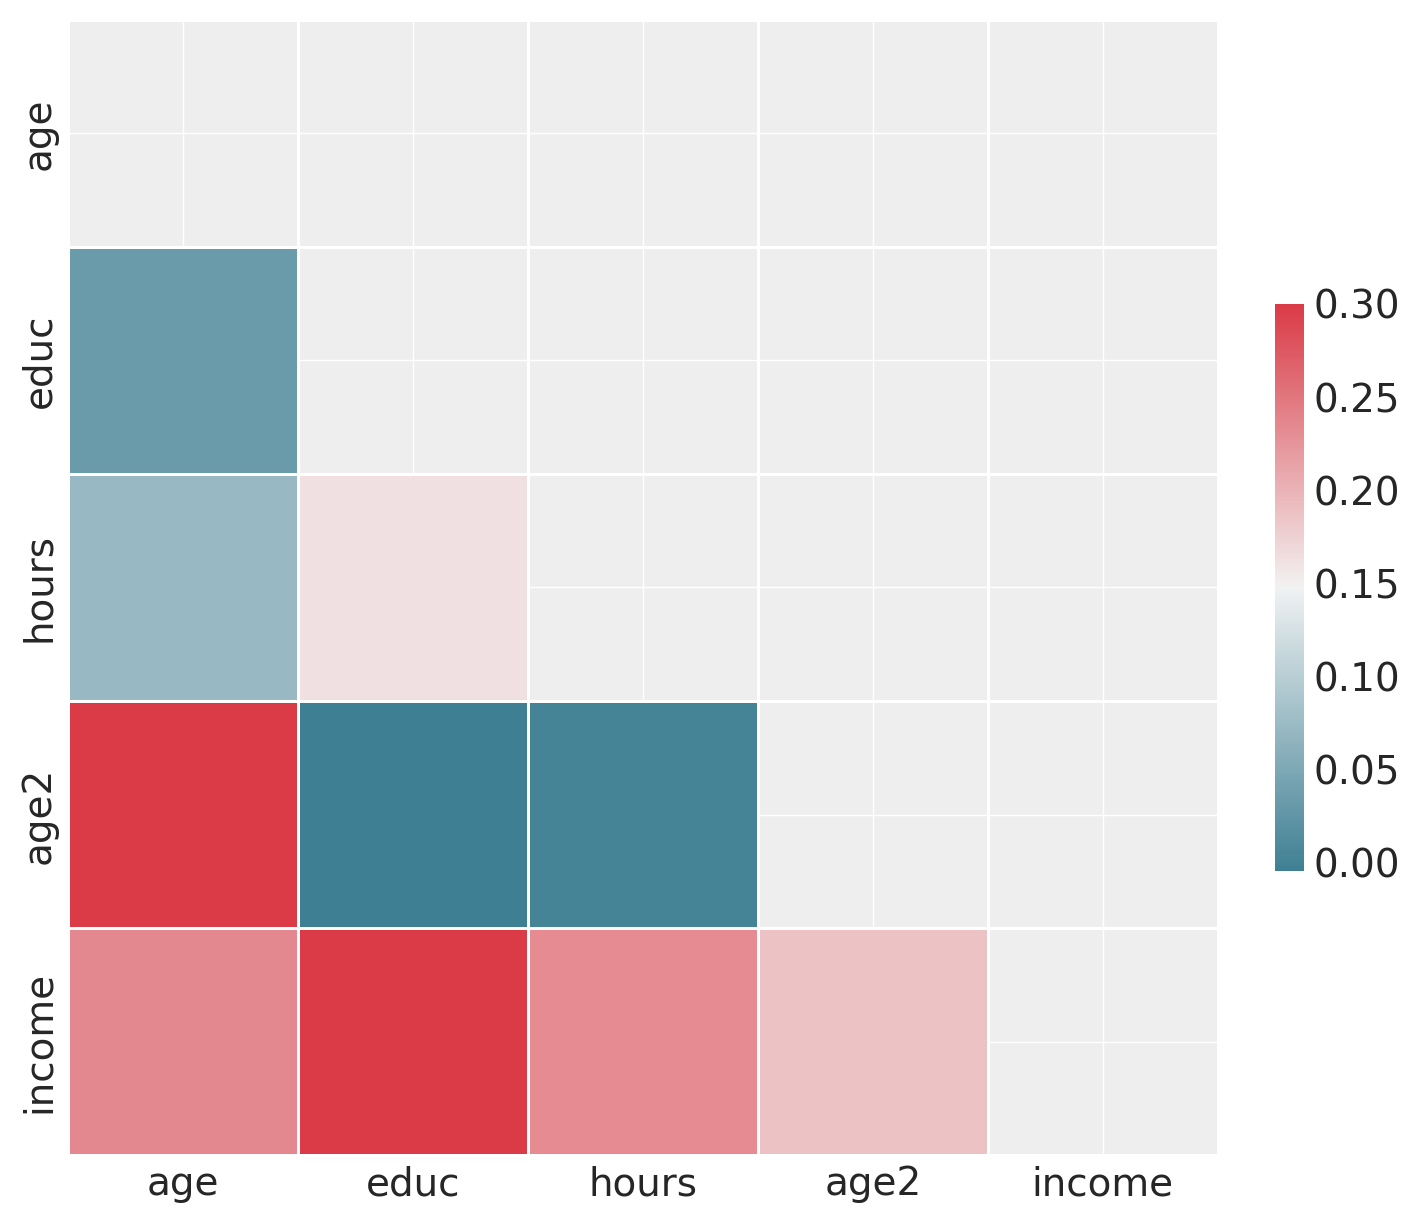

In [16]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

## 7.3 モデル
* incomeを目的変数とする。1/0の情報をベルヌーイ分布でモデリング。
* そのベルヌーイ分布のパラメータである、1が出る確率を、線形モデルでモデル化。
* 確率なので、リンク関数はlogit関数。
 * logit関数は、ロジスティック関数の逆関数。
 * 線形モデルの出力を、ロジスティック関数に与えて、確率に変換。
* 線形モデルでは、各個人のage, educ, hours特徴量を使用。
 * ただし、上述のように、ageの2乗も説明変数として追加されている。

$$ z_i = \beta_0 + \beta_1 X_{age} + \beta_2 X_{age^2} + \beta_3 X_{educ} + \beta_4 X_{hours} $$
$$ y_i \sim \text{Bernoulli}(p_i) \ , \ p_i = \frac{1}{1 + e^{-z_i}}$$

* NumPyroでロジスティック回帰を書く方法
 * https://num.pyro.ai/en/stable/handlers.html

In [17]:
D = 4
def model(data, labels=None):
  coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
  intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
  logits = jnp.sum(coefs * data, axis=-1) + intercept
  return numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=labels)

## 7.4 サンプリング

In [18]:
features = ["age", "educ", "hours", "age2"]
X = data[features].values
y = data["income"].values

In [19]:
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
mcmc.run(rng_key_, data=X, labels=y)

<ipython-input-19-bfeadb382afc>:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
sample: 100%|██████████| 3000/3000 [01:57<00:00, 25.61it/s, 31 steps of size 3.08e-02. acc. prob=0.94]


## 7.5 事後分布の確認

In [20]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   coefs[0]      2.95      0.09      2.95      2.81      3.09   1037.22      1.00
   coefs[1]      0.34      0.01      0.34      0.33      0.35   1271.03      1.00
   coefs[2]      0.03      0.00      0.03      0.03      0.04   2975.73      1.00
   coefs[3]     -0.28      0.01     -0.28     -0.29     -0.26   1050.56      1.00
  intercept    -13.16      0.21    -13.16    -13.51    -12.83   1083.79      1.00

Number of divergences: 0


In [21]:
fitted = az.from_numpyro(mcmc)

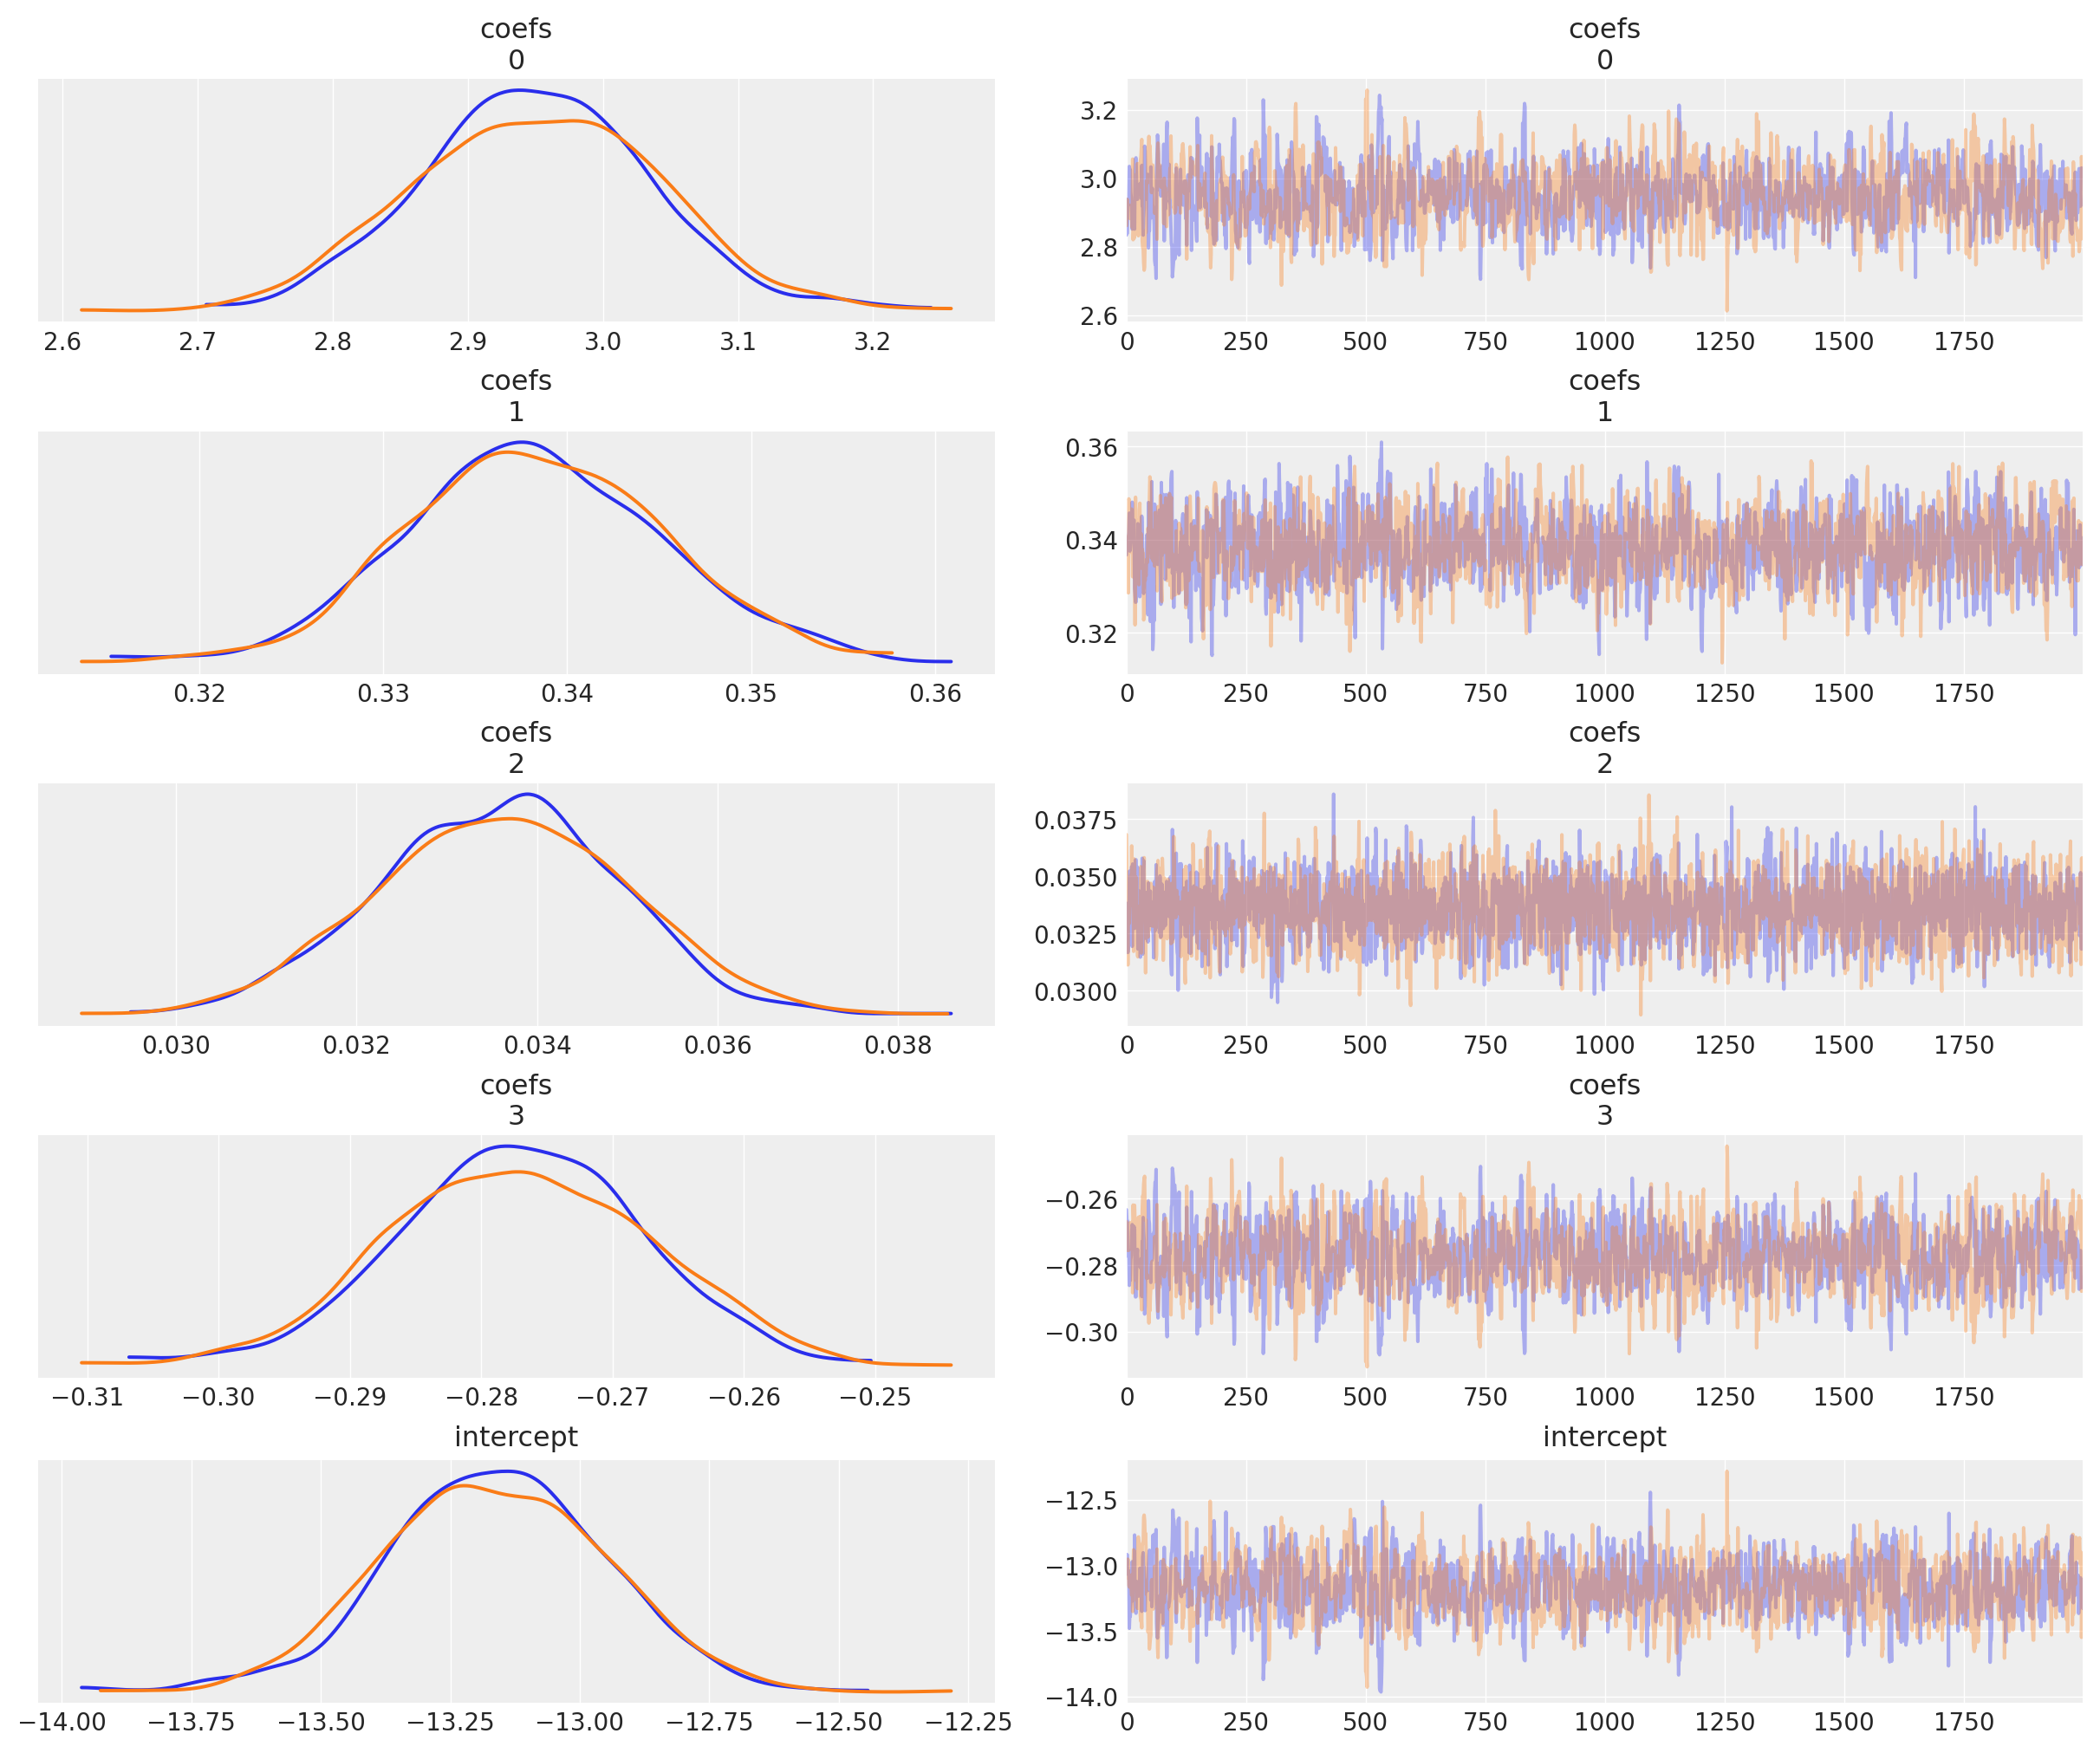

In [22]:
az.plot_trace(fitted, compact=False);

In [23]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],2.951,0.088,2.786,3.107,0.003,0.002,1042.0,1246.0,1.01
coefs[1],0.338,0.007,0.327,0.353,0.000,0.000,1286.0,1603.0,1.00
coefs[2],0.034,0.001,0.031,0.036,0.000,0.000,2984.0,2449.0,1.00
coefs[3],-0.277,0.010,-0.294,-0.259,0.000,0.000,1056.0,1241.0,1.00
intercept,-13.163,0.212,-13.552,-12.764,0.006,0.005,1088.0,1222.0,1.00


> One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our uncertainty. Maximum likelihood returns a number, but how certain can we be that we found the right number? Instead, Bayesian inference returns a distribution over parameter values.

* https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html#Some-results


* 事後分布からのサンプルを、扱いやすいように加工。
 * coefsの形は、[chainの数, drawの数, 説明変数の数]

In [24]:
print(fitted.posterior.coefs.shape)

(2, 2000, 4)


In [25]:
features

['age', 'educ', 'hours', 'age2']

In [26]:
fitted.posterior.intercept

<xarray.DataArray 'intercept' (chain: 2, draw: 2000)>
array([[-12.917596, -12.920455, -12.918443, ..., -13.309504, -13.31424 ,
        -13.327927],
       [-13.028791, -13.090995, -13.042498, ..., -13.35606 , -13.379641,
        -13.287788]], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [27]:
trace = {}
for feature in features:
  trace[feature] = fitted.posterior.coefs[:,:,features.index(feature)].data.flatten()
trace["intercept"] = fitted.posterior.intercept.data.flatten()

* 年齢の係数と教育年数の係数とでjoint plotを描いてみる。

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1760: UserWarning: The figure layout has changed to tight
  f.tight_layout()
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1761: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  f.subplots_adjust(hspace=space, wspace=space)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)


<Figure size 900x700 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


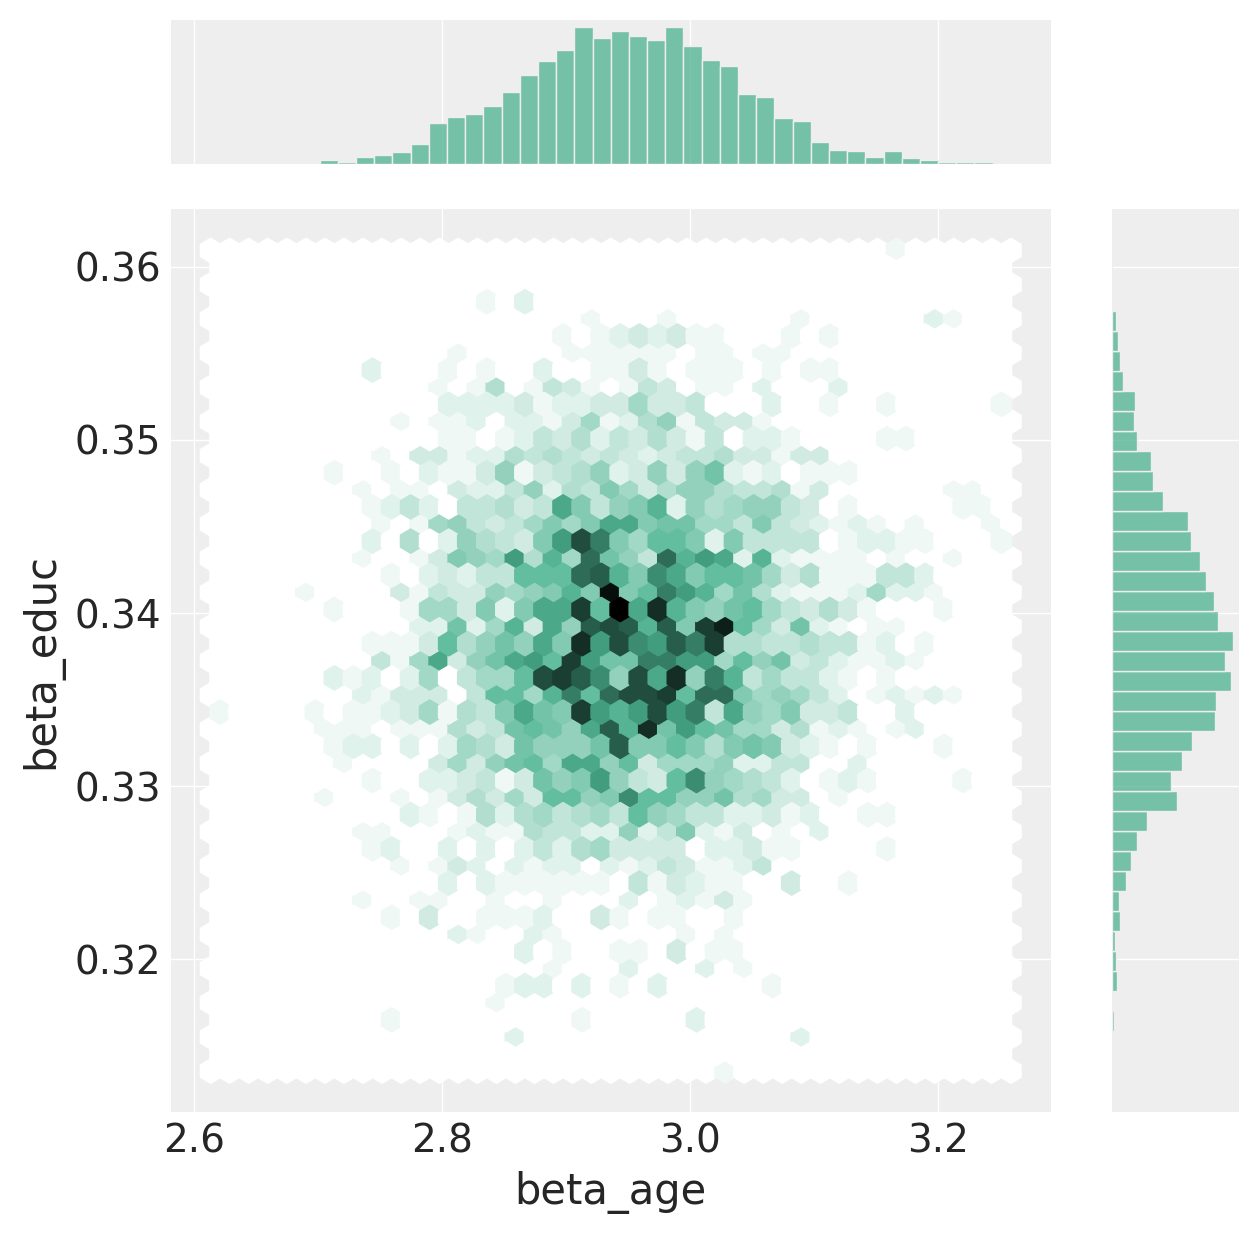

In [28]:
plt.figure(figsize=(9, 7))
sns.jointplot(x=trace["age"], y=trace["educ"], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

* ロジットの差はオッズ比の対数に当たる。
$$\log\Big(\frac{p}{1-p}\Big) - \log\Big(\frac{p^\prime}{1-p^\prime}\Big) = \log \frac{ p / (1-p) }{ p^\prime / (1 - p^\prime) }$$
* よって、GLMでリンク関数がlogit関数のとき、線形モデルの係数のexponentialは、オッズ比の差分の意味を持つ。
 * その係数に対応する説明変数の値が1増えると、線形モデルの出力が係数分だけ増える。
 * つまり、オッズ比の対数が、係数分だけ増える。

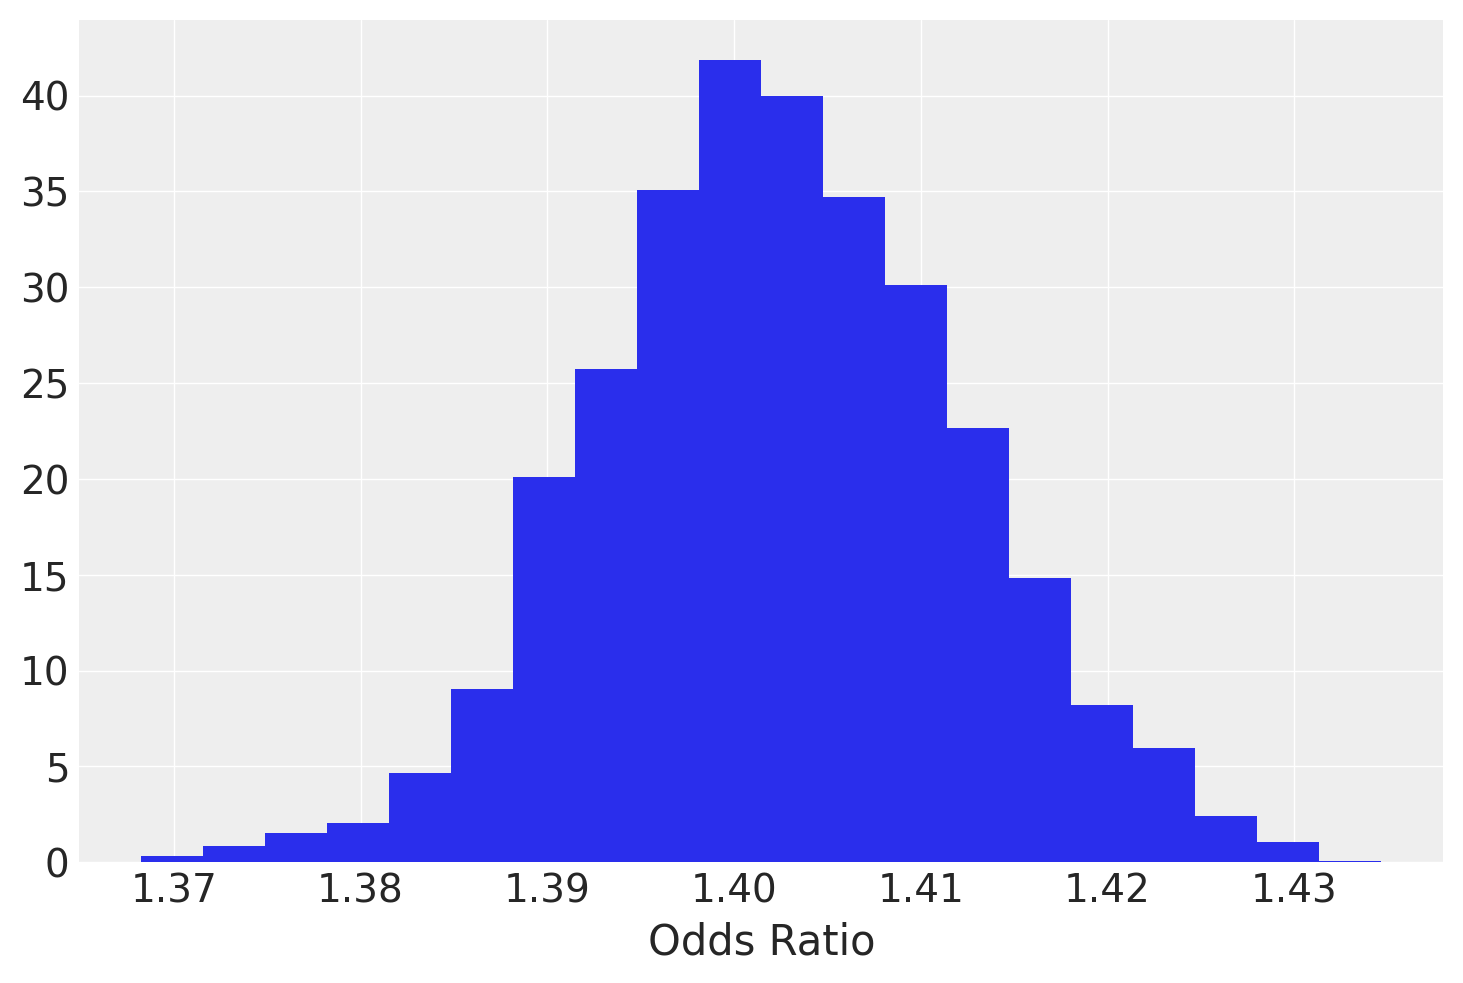

In [29]:
plt.hist(np.exp(trace["educ"]), bins=20, density=True)
plt.xlabel("Odds Ratio");

In [30]:
lb, ub = np.percentile(trace["educ"], 2.5), np.percentile(trace["educ"], 97.5)
print(f"P({np.exp(lb):.3f} < O.R. < {np.exp(ub):.3f}) = 0.95")

P(1.384 < O.R. < 1.422) = 0.95


## 7.6 Spaghetti plot of model predictions

* incomeが50Kドルを超える確率を、横軸を年齢にして、プロットする。
 * 教育年数が異なると、確率がどのように異なるかを見る。
 * 労働時間は50時間で固定する。


In [31]:
age = np.linspace(20, 80, 61) / 10.0
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "educ": np.repeat([12, 16, 19], len(age)),
    "hours": 50.0,
    "age2": np.tile(age, 3) ** 2,
})

In [32]:
new_data

,age,educ,hours,age2
0,2.0,12,50.0,4.00
1,2.1,12,50.0,4.41
2,2.2,12,50.0,4.84
3,2.3,12,50.0,5.29
4,2.4,12,50.0,5.76
...,...,...,...,...
178,7.6,19,50.0,57.76
179,7.7,19,50.0,59.29
180,7.8,19,50.0,60.84
181,7.9,19,50.0,62.41


In [33]:
posterior_logit = jnp.expand_dims(trace["intercept"], 0)
for column in data.columns:
  if column == "income": continue
  posterior_logit += (
      jnp.expand_dims(new_data[column].values, -1) 
      * jnp.expand_dims(trace[column], 0)
  )

In [34]:
posterior_logit = posterior_logit[:, ::20]

In [35]:
posterior_logit.shape

(183, 200)

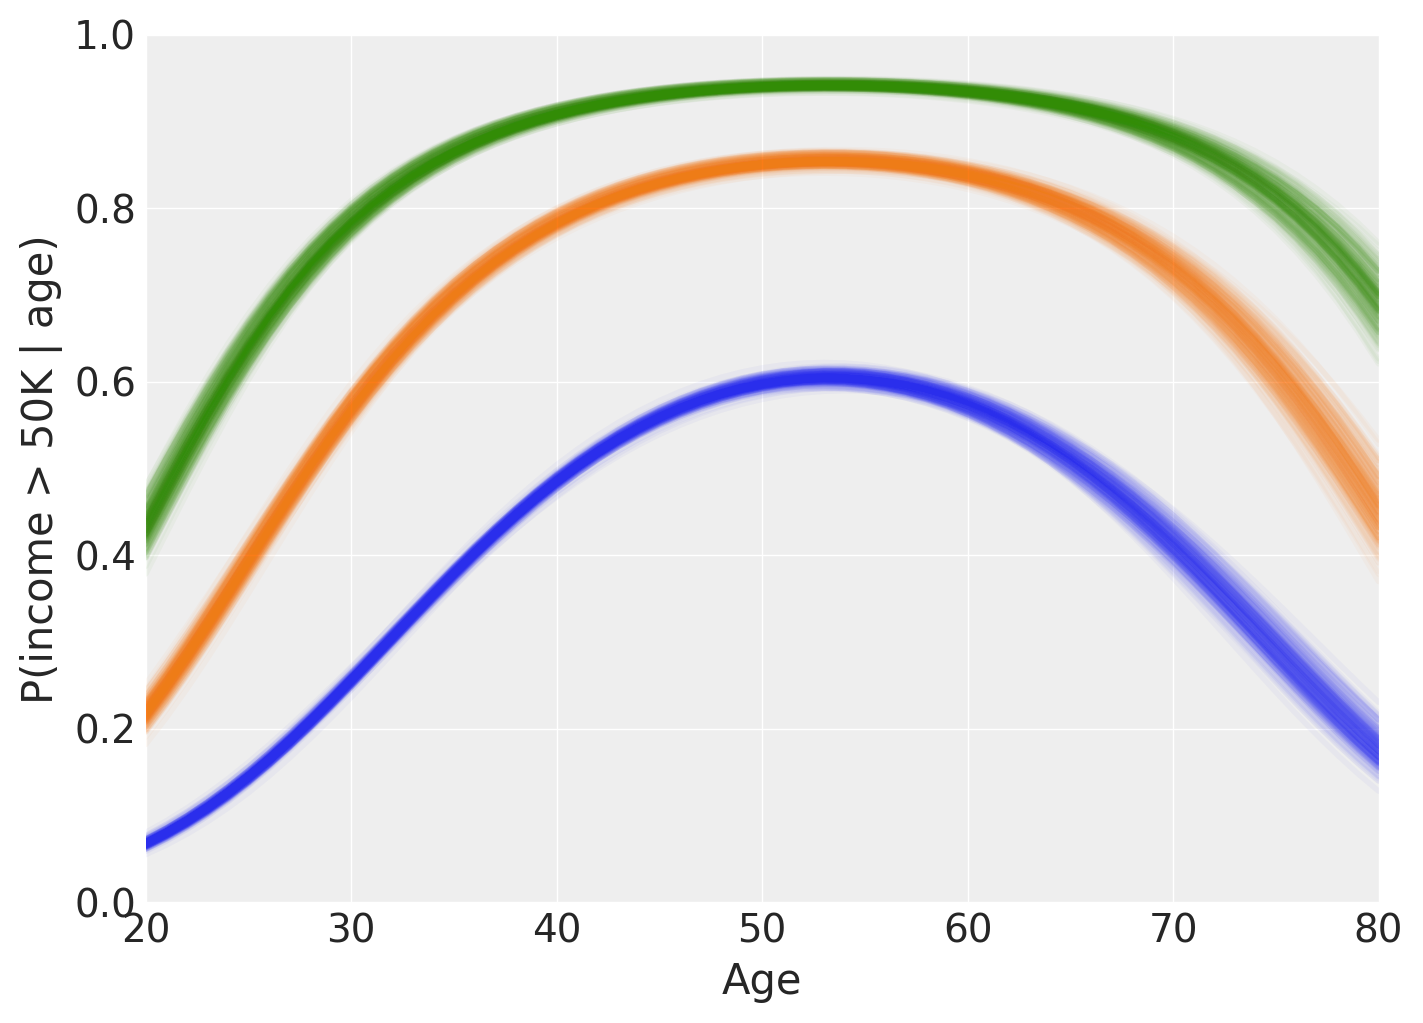

In [36]:
_, ax = plt.subplots(figsize=(7, 5))

for i, educ in enumerate([12, 16, 19]):
    # Which rows in new_data correspond to party?
    idx = new_data.index[new_data["educ"] == educ].tolist()
    ax.plot(age * 10, 1 / (1 + np.exp(- posterior_logit[idx,:])),
            alpha=0.04, color=f"C{i}")

ax.set_ylabel("P(income > 50K | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(0, 1)
ax.set_xlim(20, 80);